In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

import torch
from torchvision import datasets,transforms,models
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from myDatasets import *

In [2]:
data_dir='/Users/nithin_rao/MyFiles/MS/USC/Internships/BrainCorp/find_phone_task_4/find_phone/'

In [3]:
label_ids = !cut -f 1 -d ' ' $data_dir/labels.txt
label_loc_x = !cut -f 2 -d ' ' $data_dir/labels.txt
label_loc_y = !cut -f 3 -d ' ' $data_dir/labels.txt
label_loc_x = np.asarray(label_loc_x,dtype=np.float32).reshape(-1,1)
label_loc_y = np.asarray(label_loc_y,dtype=np.float32).reshape(-1,1)
labels = np.hstack((label_loc_x,label_loc_y)) 

filenames = [data_dir+file for file in label_ids]

In [4]:
tfms = transforms.Compose([transforms.ToPILImage(),
                           transforms.Resize((224,224)),
                            transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406),
                                               (0.229, 0.224, 0.225))])

train_per = 0.7
len_filenames = len(filenames)
train_filenames = filenames[:int(train_per*len_filenames)]
valid_filenames = filenames[int(train_per*len_filenames):]

train_labels = labels[:int(train_per*len_filenames)]
valid_labels = labels[int(train_per*len_filenames):]

train_dset_natural = ImageDataset(train_filenames,train_labels,tfms=tfms)
train_dset_hflip = ImageDataset_hflip(train_filenames,train_labels,tfms=tfms)
train_dset_vflip = ImageDataset_vflip(train_filenames,train_labels,tfms=tfms)

train_dataset = data.ConcatDataset([train_dset_natural,train_dset_hflip,train_dset_vflip])
valid_dataset = ImageDataset(valid_filenames,valid_labels,tfms=tfms)

train_loader = data.DataLoader(train_dataset,batch_size=1,shuffle=True)
valid_loader = data.DataLoader(valid_dataset,batch_size=1,shuffle=True)

In [5]:
def imshow(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)

In [6]:
train_loader = data.DataLoader(train_dataset,batch_size=16,shuffle=True)

In [7]:
x,y = next(iter(train_loader))

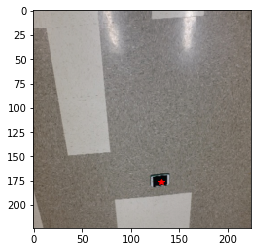

In [8]:
imshow(x[0])
plt.plot(y[0,0],y[0,1],marker='*',color='r')
plt.show()

In [9]:
model = models.vgg16(pretrained=True)

In [10]:
for param in model.parameters():
    param.requires_grad=False

In [13]:
from collections import OrderedDict

regressor=nn.Sequential(OrderedDict([
#                           ('dropout1',nn.Dropout(0.6)),
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
#                           ('dropout2',nn.Dropout(0.6)),
#                           ('fc2', nn.Linear(512, 50)),
#                           ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(4096, 100)),
                            ('relu2', nn.ReLU()),
                            ('fc3', nn.Linear(100, 2))
#                           ('output', nn.Sigmoid())
                          ]))

In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
model.classifier = regressor

In [14]:
# print(model)

In [16]:
criterion = nn.L1Loss()
learning_rate = 2e-3
optimizer = torch.optim.Adam(model.classifier.parameters())

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def distance(labels,predict,steps=1):
    dist= torch.sum((labels-predict)**2,1)
    mask = 0*dist;
    mask[dist<=0.05]=1
    if steps % 5==0:
        print(predict)
    return mask

def evaluate(model, dataloader, criterion, device):
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for img,labels in iter(dataloader):
                img,labels = img.to(device), labels.to(device)
                
                output = model.forward(img)
                loss += criterion(output,labels).item()
                
                accuracy += distance(output,labels).mean()
    return loss,accuracy

In [18]:
import pdb

In [19]:
model.to(device)
epochs = 5
print_every = 2

steps = 0
running_loss=0
train_accuracy=0
valid_loss_min = np.Inf

for e in range(epochs):
    
    model.train()
    
    for images,labels in iter(train_loader):
        images,labels = images.to(device),labels.to(device)
        
        steps+=1
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
#         pdb.set_trace()
        train_accuracy += distance(labels,output,steps).mean()
        
        if steps % print_every==0 :
            model.eval()
            
            with torch.no_grad():
                valid_loss, valid_accuracy= evaluate(model,valid_loader,
                                                    criterion,
                                                    device)
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                        "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                        "Training Accuracy: {:.3f}".format(train_accuracy/print_every),
                        "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)),
                        "Validation Accuracy: {:.3f}".format(valid_accuracy/len(valid_loader)))
                
#           if valid_loss < valid_loss_min:
#               savemodel()
#               valid_loss_min = valid_loss
            running_loss=0
            train_accuracy=0
            model.train()

print("\n Training Done")
                

RuntimeError: size mismatch, m1: [16 x 4096], m2: [100 x 2] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940

In [ ]:
with torch.no_grad():
    output = model.forward(x[1].unsqueeze(0))

In [ ]:
output

In [ ]:
y[1]

In [ ]:
for i in range(16):
    with torch.no_grad():
        output = model.forward(x[i].unsqueeze(0))
    imshow(x[i])
    plt.plot(y[i,0],y[i,1],marker='*',color='r')
    print(output)
    plt.plot(output[0,0],output[0,1],marker='*',color='b')
    plt.show()

In [ ]:
output